In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from scipy.stats import spearmanr

{'seed': 1, 'n_samps': 1500, 'z_param': {'spike_grp': ['left', 'mid', 'right'], 'n_repetitions': 1, 'rel_noise_list': [0.1, 0.1]}, 'x_param': {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 150, 'rel_noise_list': [0.1], 'seed_offset': 0}, 'n_trials': 100, 'noise_levs': [], 'sparsities': [], 'target_vars': 5994, 'methods': ['unsup_graph', 'graph'], 'graph_k': 10, 'n_perms': 10000, 'alpha': 0.05, 'perm_method': 'pool', 'sim_dir': '/share/PI/sabatti/feat_viz/corr_sim/regime_2', 'save': True, 'check_skip': False, 'null_struct': {'model': 'normal', 'block_size': 150, 'corr_value': 0.4, 'scale': 0.5, 'seed': 10}, 'method_params': {'method': 'graph', 'n_perms': 10000, 'perm_method': 'pool', 'alpha': 0.05, 'graph_k': 10}}


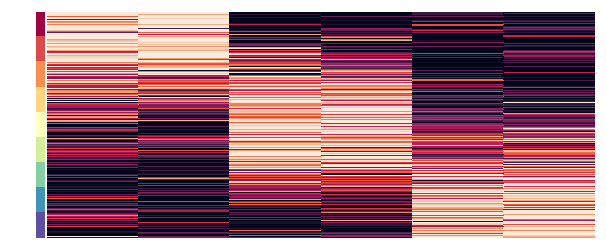

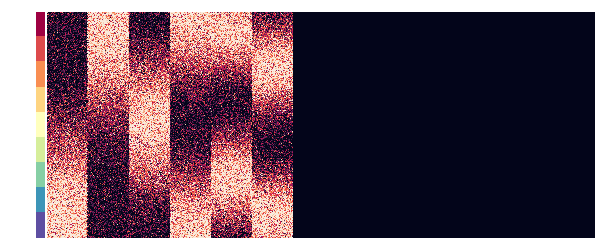

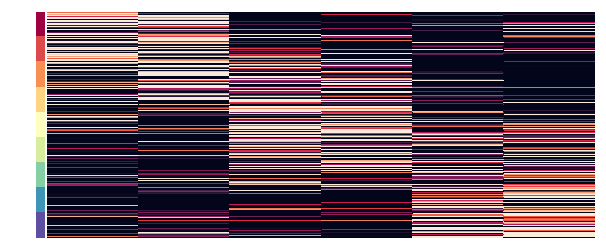

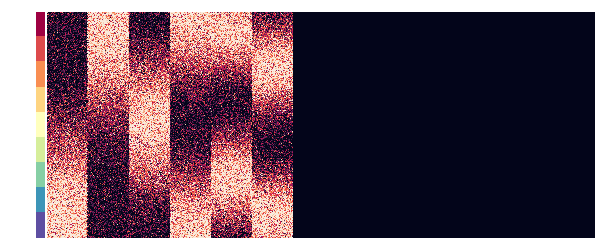

In [3]:
from sim_utils import get_corr_sim, generate_invariant_data, model_corr_noise
from plot_utils import plot_ground_truth_heatmap, plot_spike_grps

sim_params = get_corr_sim(regime=2)
print(sim_params)
# generate invariant data
lam_true, z_init, x_init, var_df = generate_invariant_data(sim_params)
plot_ground_truth_heatmap(lam_true, z_init)
plot_ground_truth_heatmap(lam_true, x_init[:,:2000])
z, x, v_df = model_corr_noise(sim_params['null_struct'], z_init, x_init)
var_df = pd.concat([var_df, v_df], axis=1)
# mtx = np.concatenate([z, x], axis=1)
# n_lm_genes = z.shape[1]
plot_ground_truth_heatmap(lam_true, z)
plot_ground_truth_heatmap(lam_true, x_init[:,:2000])

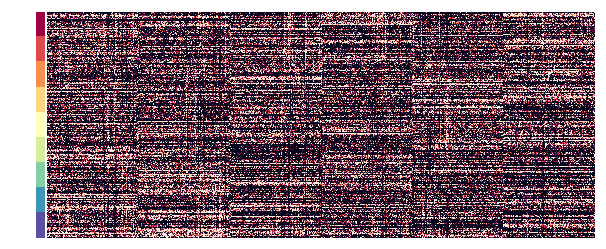

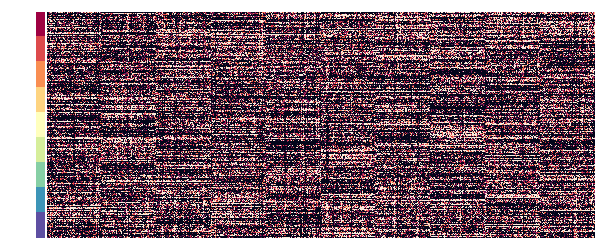

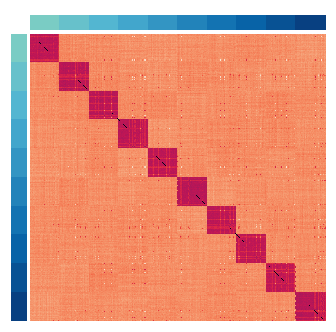

In [32]:
from plot_utils import plot_by_noise_struct
plot_by_noise_struct(var_df, lam_true, x, num_grps = 10)

In [7]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure
from sim_utils import selction_eval

result = run_procedure(z, x, sim_params['method_params'])
selction_eval(result, lam_true, sim_params, var_df)
result.keys()

{'FDP': 0.025279247501469725, 'Power': 0.9910340705319785, 'Corr': 0.9950108920048409, 'Num_Nonnulls': 1673, 'Num_Rejections': 1701}


dict_keys(['lam_init', 'lam_update', 'p_vals', 'rejections'])

In [8]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin

# get the variable group ids
lam = result["lam_update"]
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, x, base_args)

cr(x, knots=(-0.012, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters


In [4]:
var_df.head()

,var_id,nn_grp,corr_grp,lm_corr
0,0,0,12,False
1,1,0,19,True
2,2,0,25,False
3,3,0,0,False
4,4,0,16,False


## TODO: save current data

In [24]:
embed_dict['rejected_coeffient'].head()

,umap 1,umap 2,id,var
0,4.050073,16.542179,0,0
1,3.303834,16.326290,1,0
2,3.241414,16.220198,2,0
3,3.991628,16.408190,3,0
4,4.641462,15.367262,4,0


In [27]:
def save_curr_data(var_df, z, x, lam, c_mtx):
    npy_data = {'z': z, 
                'x': x, 
                'lam': lam,
                'c': c_mtx}
    
    df_data = {'var_df': var_df}

In [35]:
import umap
from plot_utils import plot_scatter_discrete
def compute_embedding(mtx, sel_idx=None):
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(mtx.shape[0])
    print("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    return df

def compute_all_embeddings(c_mtx, x):
    embed_dict = {}
    sel_list = ["all", "rejected"]
    mat_list = ["coeffient", "expression"]
    for sel in sel_list:
        if sel == "rejected":
            sel_idx = result["rejections"]
        else:
            sel_idx = None
        for mat in mat_list:
            if mat == "coeffient":
                in_mtx = c_mtx
            else:
                in_mtx = x.T
            key = "{}_{}".format(sel, mat)
            print("Computing embedding for: {}".format(key))
            df = compute_embedding(in_mtx, sel_idx=sel_idx)
            embed_dict[key] = df
    return embed_dict

embed_dict = compute_all_embeddings(c_mtx, x)

Computing embedding for: all_coeffient
input dimension: (5994, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: all_expression
input dimension: (5994, 1500)
Computing embedding for: rejected_coeffient
input dimension: (1701, 5)


/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


Computing embedding for: rejected_expression
input dimension: (1701, 1500)


Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 5094, 0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})
Counter({-1: 810, 0: 150, 1: 150, 2: 150, 3: 150, 5: 147, 4: 144})


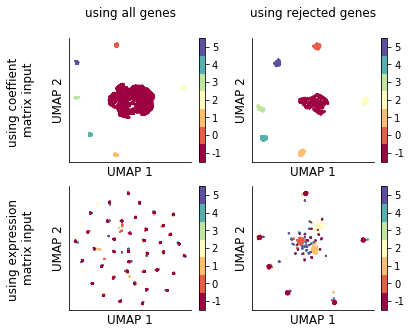

In [36]:
from collections import Counter
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = var_df.loc[plt_df["id"]]['nn_grp'].values
        print("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
# plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

# Corr = 0.5

[feat_viz INFO] Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 5094, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 833, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 147, 5.0: 147})
[feat_viz INFO] Counter({-1.0: 833, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 147, 5.0: 147})


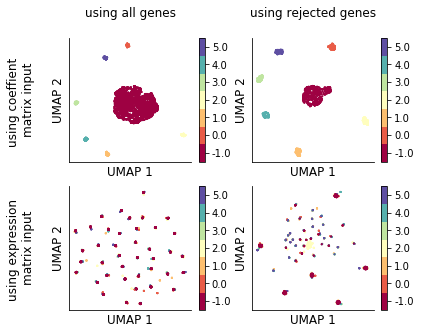

In [10]:
from collections import Counter
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = plt_df["var"]
        logger.info("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
# plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

# OLD STUFF

In [57]:
h1_params = sim_params["x_param"]
h0_params = sim_params["null_struct"]
num_h0_grps = 8
num_h1_grps = len(h1_params["spike_grp"])
h0_grp_ids = np.arange(num_h0_grps) + num_h1_grps
h1_grp_ids = np.arange(num_h1_grps)

h0_ids = np.repeat(h0_grp_ids,  h0_params["block_size"])
h1_ids = np.repeat(h1_grp_ids,  h1_params["n_repetitions"])
grp_ids = list(h1_ids) + list(h0_ids)

x_unsorted = x[:, :len(grp_ids)]
sort_idx = np.argsort(lam_true)
x_sorted = x_unsorted[sort_idx,]
print("Matrix dim: {}".format(x_unsorted.shape))

z, _ = generate_spike_mtx(lam_true, **sim_params["z_param"])

Matrix dim: (1500, 2100)


In [24]:
# TODO:
# 1. run g-aloe on this to make sure the correct variables are selected
# 2. fit splines on the selected variables (using spline fit) -> feat_viz
# 3. collect the parameter matrix -> feat_viz
from main_methods import run_procedure, run_unsupervised, evaluate_result
from general_utils import evaluate_rejections

meth_params = {
    "method": "graph",
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}
result = run_procedure(z, x, meth_params)
result.keys()
n_proto = len(x_param["spike_grp"])
n_rep = x_param["n_repetitions"]
nn_idx = np.arange(n_rep*n_proto)
rej_idx = result["rejections"]
mt_res = evaluate_rejections(set(rej_idx), set(nn_idx))
mt_res["Corr"] = abs(spearmanr(result["lam_update"], lam_true).correlation) 
mt_res

[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...


{'FDP': 0.0488997555012225,
 'Power': 0.43222222222222223,
 'Corr': 0.9825708722537211}

## TODO: use gap statistic and k-means/ spectral clustering to identify the clusters

In [25]:
# fit the spline with updated lambda and the x features
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
zone_true = rank_and_bin(lam_true, n_bins=9)
lam = result["lam_update"]
var_ids = np.ones(x.shape[1]) * -1
for i in range(n_proto):
    var_ids[i*(n_rep): (i+1)*n_rep] = i
base_args = setup_basis(lam)
print(base_args)
p_fun, c_mtx = spline_fit(lam, x, base_args)

cr(x, knots=(-0.012, 0.013))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters


In [26]:
import umap
from plot_utils import plot_scatter_discrete
def compute_embedding(mtx, var_names, sel_idx=None):
    assert mtx.shape[0] == len(var_names), "dim mismatch"
    uobj = umap.UMAP(random_state=10101)
    if sel_idx is None:
        sel_idx = np.arange(len(var_names))
    logger.info("input dimension: {}".format(mtx[sel_idx, :].shape))
    embedding = uobj.fit_transform(mtx[sel_idx, :])
    df = pd.DataFrame(embedding, columns=["umap 1", "umap 2"])
    df["id"] = sel_idx
    df["var"] = var_names[sel_idx]
    return df

embed_dict = {}
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
for sel in sel_list:
    if sel == "rejected":
        sel_idx = rej_idx
    else:
        sel_idx = None
    for mat in mat_list:
        if mat == "coeffient":
            mtx = c_mtx
        else:
            mtx = x.T
        key = "{}_{}".format(sel, mat)
        logger.info("Computing embedding for: {}".format(key))
        df = compute_embedding(mtx, var_ids, sel_idx=sel_idx)
        embed_dict[key] = df

[feat_viz INFO] Computing embedding for: all_coeffient
[feat_viz INFO] input dimension: (9000, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components
[feat_viz INFO] Computing embedding for: all_expression
[feat_viz INFO] input dimension: (9000, 1500)
[feat_viz INFO] Computing embedding for: rejected_coeffient
[feat_viz INFO] input dimension: (409, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
[feat_viz INFO] Computing embedding for: rejected_expression
[feat_viz INFO] input dimension: (409, 1500)


[feat_viz INFO] Counter({-1.0: 8100, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({-1.0: 8100, 0.0: 150, 1.0: 150, 2.0: 150, 3.0: 150, 4.0: 150, 5.0: 150})
[feat_viz INFO] Counter({0.0: 150, 1.0: 150, 2.0: 38, 3.0: 32, -1.0: 20, 5.0: 11, 4.0: 8})
[feat_viz INFO] Counter({0.0: 150, 1.0: 150, 2.0: 38, 3.0: 32, -1.0: 20, 5.0: 11, 4.0: 8})


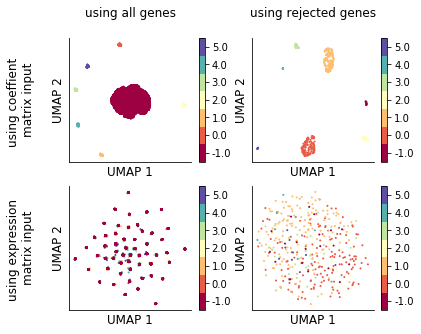

In [27]:
from collections import Counter
fontsize = 12
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        var_labs = plt_df["var"]
        logger.info("{}".format(Counter(var_labs)))
        plot_scatter_discrete(plt_df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=1)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_genes.pdf")
plt.show()

[feat_viz INFO] Fitted points stored in (50, 193)


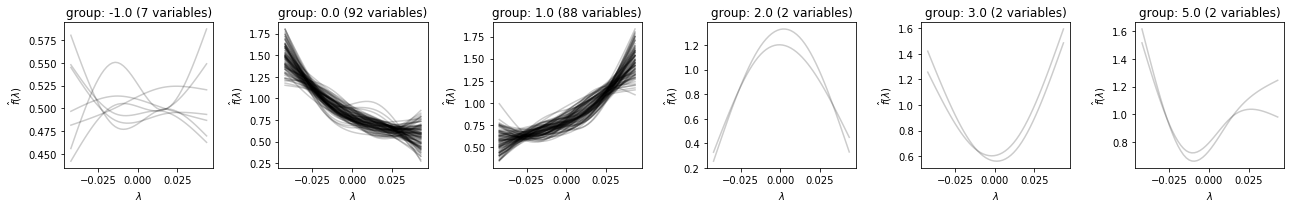

In [11]:
# partition the variables into groups
from patsy import dmatrix
clust_labs = var_ids
coeff_mtx = c_mtx 
# x = result["lam_update"]

def plot_multi_curves(ax, x, y_mtx, **kwargs):
    assert len(x) == y_mtx.shape[0], "dimension mismatch"
    for i in range(y_mtx.shape[1]):
        ax.plot(x, y_mtx[:,i], **kwargs)

def refit_curves(coeff_mtx, base_args, x):
    x = np.linspace(min(x), max(x), 50)
    exog = dmatrix(base_args, {"x": x}, return_type='dataframe')
    y = np.matmul(exog.values, coeff_mtx.T)
    logger.info("Fitted points stored in {}".format(y.shape))
    return x, y

def plot_group_curves(coeff_mtx, clust_labs, base_args, x_init):
    x_vals, fit_mtx = refit_curves(coeff_mtx, base_args, x_init)
    assert coeff_mtx.shape[0] == len(clust_labs), "dimension mismatch"
    unique_labs = np.unique(clust_labs)

    # compute the fitted curves for all genes on the right space
    fig, axes = plt.subplots(1, len(unique_labs), figsize=(3*len(unique_labs),3))
    for i_ax, i_lab in enumerate(unique_labs):
        ax = axes[i_ax]
        sel_var_idx = [i for i, lab in enumerate(clust_labs) if lab == i_lab]

        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_var_idx], 
                          alpha=0.2, color="black")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\hat{f}(\lambda)$")
        ax.set_title(r"group: {} ({} variables)".format(i_lab, len(sel_var_idx)))
    plt.tight_layout()
    plt.show()
    
plot_group_curves(c_mtx[rej_idx, :], var_ids[rej_idx], base_args, result["lam_update"])


[feat_viz INFO] Fitted points stored in (50, 9000)


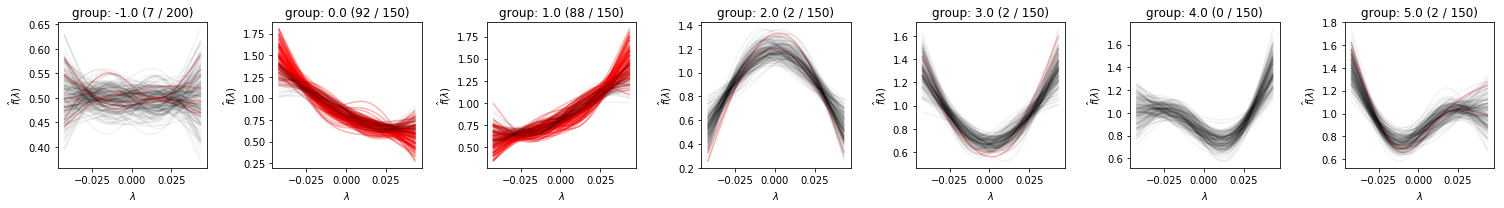

In [12]:
def plot_reject_group_curves(rej_idx, coeff_mtx, clust_labs, base_args, x_init, max_lines=200):
    x_vals, fit_mtx = refit_curves(coeff_mtx, base_args, x_init)
    assert coeff_mtx.shape[0] == len(clust_labs), "dimension mismatch"
    unique_labs = np.unique(clust_labs)

    # compute the fitted curves for all genes on the right space
    fig, axes = plt.subplots(1, len(unique_labs), figsize=(3*len(unique_labs),3))
    for i_ax, i_lab in enumerate(unique_labs):
        ax = axes[i_ax]
        # total selection
        sel_var_idx = [i for i, lab in enumerate(clust_labs) if lab == i_lab]
        # rejections
        sel_rej_idx = list(set(rej_idx).intersection(set(sel_var_idx)))
        # remaining
        sel_acc_idx = list(set(sel_var_idx).difference(set(rej_idx)))
        sel_acc_idx = sel_acc_idx[:min(max_lines-len(sel_rej_idx),len(sel_acc_idx))]
        rej_alpha = 0.3
        acc_alpha = 0.5
        if (len(sel_acc_idx) * 2  > len(sel_rej_idx)):
            acc_alpha = 0.05            
        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_rej_idx], 
                          alpha=rej_alpha, color="red")
        plot_multi_curves(ax, x_vals, fit_mtx[:, sel_acc_idx], 
                          alpha=acc_alpha, color="black")
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\hat{f}(\lambda)$")
        ax.set_title(r"group: {} ({} / {})".format(i_lab, len(sel_rej_idx), 
                                                   len(sel_rej_idx) + len(sel_acc_idx)))
    plt.tight_layout()
    plt.savefig("/scratch/users/jjzhu/tmp_fig/spline_curves.pdf")
    plt.show()
    
plot_reject_group_curves(rej_idx, c_mtx, var_ids, base_args, result["lam_update"])


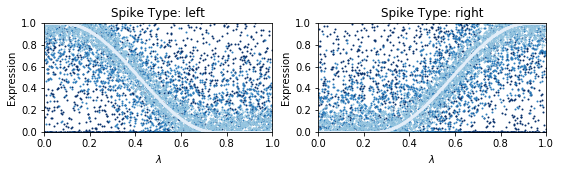

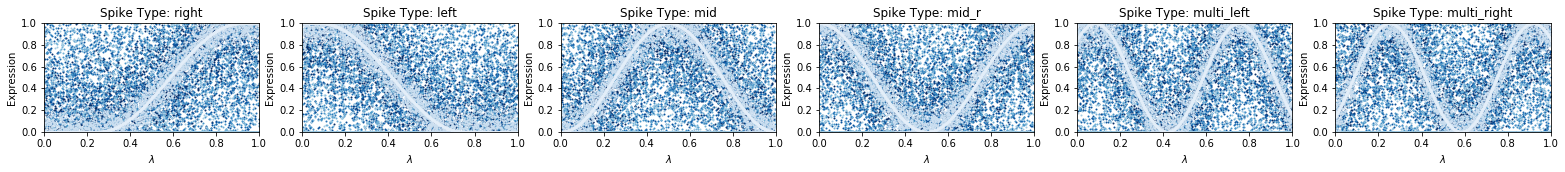

[feat_viz INFO] {'spike_grp': ['right', 'left', 'mid', 'mid_r', 'multi_left', 'multi_right'], 'n_repetitions': 300, 'rel_noise_list': [0.5], 'seed_offset': 100}
[feat_viz INFO] Null structure: {'model': 'normal', 'block_size': 150, 'corr_value': 0.5}


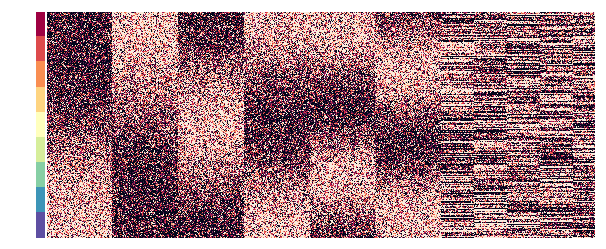

In [13]:
visualize_setup(sim_id, plot_mtx=True)

# OLD

In [14]:
from main_methods import run_procedure, run_unsupervised, evaluate_result
from general_utils import evaluate_rejections

meth_params = {
    "method": "graph",
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}
z, _ = generate_spike_mtx(lam_true, **sim_params["z_param"])
result = run_procedure(z, x, meth_params)
result.keys()
n_proto = len(x_param["spike_grp"])
n_rep = x_param["n_repetitions"]
nn_idx = np.arange(n_rep*n_proto)
rej_idx = result["rejections"]
mt_res = evaluate_rejections(set(rej_idx), set(nn_idx))
mt_res["Corr"] = abs(spearmanr(result["lam_update"], lam_true).correlation) 
mt_res

[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...


{'FDP': 0.038461538461538464,
 'Power': 0.2222222222222222,
 'Corr': 0.929567837141261}

## Proposed

In [15]:
# compute the spline embedding
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin
base_args = setup_basis(result["lam_update"])
print(base_args)
p_fun, c_mtx = spline_fit(result["lam_update"], x_unsorted, base_args)
x_ours = c_mtx.T

cr(x, knots=(-0.015, 0.014))
Fitted 1000 parameters
Fitted 2000 parameters


## Oracle

In [16]:
base_args = setup_basis(lam_true)
print(base_args)
p_fun, c_mtx = spline_fit(lam_true, x_unsorted, base_args)
x_oracle = c_mtx.T

cr(x, knots=(0.333, 0.666))
Fitted 1000 parameters
Fitted 2000 parameters


# visualization

In [18]:
import umap
from general_utils import norm_mtx
from plot_utils import plot_scatter_discrete
from plot_utils import create_color_map, clear_sns_dendogram

def compute_embedding(mtx):
    uobj = umap.UMAP(random_state=10101)
    logger.info("input dimension: {}".format(mtx.shape))
    embedding = uobj.fit_transform(mtx)
    return embedding
viz_unsorted = compute_embedding(norm_mtx(x_unsorted).T)
viz_ours = compute_embedding(norm_mtx(x_ours).T)
viz_oracle = compute_embedding(norm_mtx(x_oracle).T)

[feat_viz INFO] input dimension: (2100, 1500)
[feat_viz INFO] input dimension: (2100, 5)
[feat_viz INFO] input dimension: (2100, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


In [19]:
# get the label-to-color mapping
h1_map = create_color_map(h1_grp_ids, "RdPu", start=0.5, end=1)
h0_map = create_color_map(h0_grp_ids, "GnBu", start=0.5, end=1)
lut = h1_map.copy()
lut.update(h0_map)
feat_cols = pd.Series(grp_ids).map(lut)

In [ ]:
# unsupervised
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_scatter_discrete(viz_unsorted, grp_ids, ax=ax, ms=1, cols=lut)     
plt.show()
# our proposal
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_scatter_discrete(viz_ours, grp_ids, ax=ax, ms=1, cols=lut)     
plt.show()
# oracle
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_scatter_discrete(viz_embedd, grp_ids, ax=ax, ms=1, cols=lut)     
plt.show()

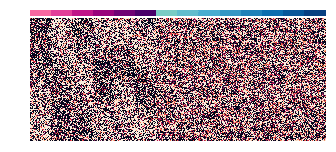

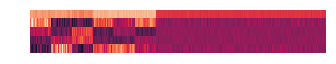

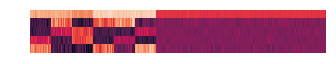

In [168]:
def plot_col_color_heatmap(plt_mtx, grp_ids, lut, val_min=None, val_max=None,
                           short=False, square=False):
    feat_cols = pd.Series(grp_ids).map(lut)
    if val_min:
        plt_mtx[plt_mtx < val_min] = val_min
    if val_max:
        plt_mtx[plt_mtx > val_max] = val_max

    pad_white = pd.Series(np.repeat("#ffffff", len(grp_ids)))
    if square:
        figsize=(7, 7)
        shared_cols = [feat_cols] * 10 +  [pad_white] * 1
        col_colors = shared_cols
        row_colors = shared_cols
    else:
        if short:
            figsize=(7, 1)
            col_colors = None
            row_colors = [pad_white]
        else:
            figsize=(7, 3)
            col_colors = [feat_cols] * 10 +  [pad_white] * 1
            row_colors = [pad_white]
   
    grid = sns.clustermap(plt_mtx, xticklabels=False, yticklabels = False,
                          row_cluster=False, col_cluster=False, 
                          col_colors=col_colors, row_colors = row_colors,
                          figsize=figsize)
    clear_sns_dendogram(grid)
plot_col_color_heatmap(x_sorted, grp_ids, lut, val_min=0, val_max=1)
plot_col_color_heatmap(x_ours, grp_ids, lut, short=True)
plot_col_color_heatmap(x_oracle, grp_ids, lut, short=True)

# DEBUG

What happends if you forget to scale the matrix input

[feat_viz INFO] input dimension: (2100, 1500)
[feat_viz INFO] input dimension: (2100, 5)
/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


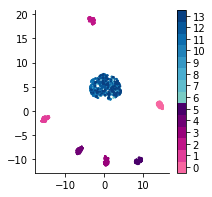

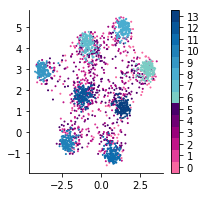

In [46]:
viz_unsorted = compute_embedding(x_unsorted.T)
viz_embedd = compute_embedding(x_embed.T)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_scatter_discrete(viz_embedd, grp_ids, ax=ax, ms=1, cols=lut)     
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_scatter_discrete(viz_unsorted, grp_ids, ax=ax, ms=1, cols=lut)     
plt.show()

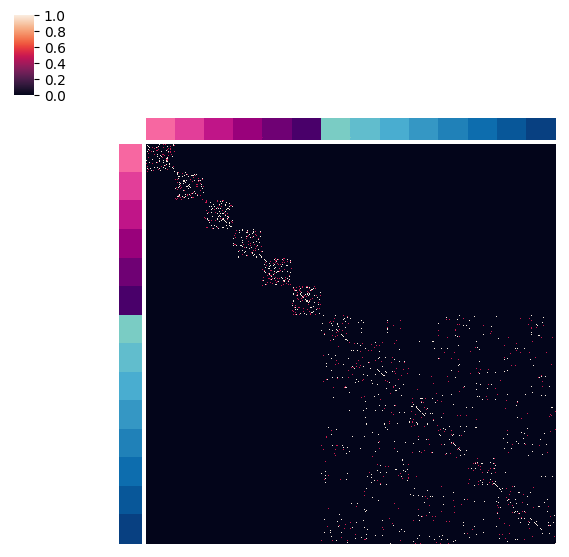

In [202]:
def comp_dist_plot_heatmap(x_in):
#     dist_feat = np.exp(-pairwise_distances(x_in.T, metric="euclidean") ** 2)
    dist_feat = construct_knn_naive(x_in.T).toarray()
    return dist_feat
dist_feat = comp_dist_plot_heatmap(x_embed)
plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True)

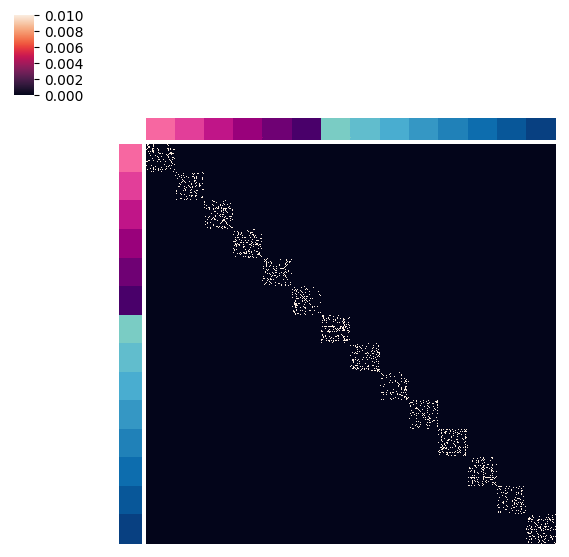

In [203]:
dist_feat = comp_dist_plot_heatmap(x_sorted)
plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True, val_max=0.01)

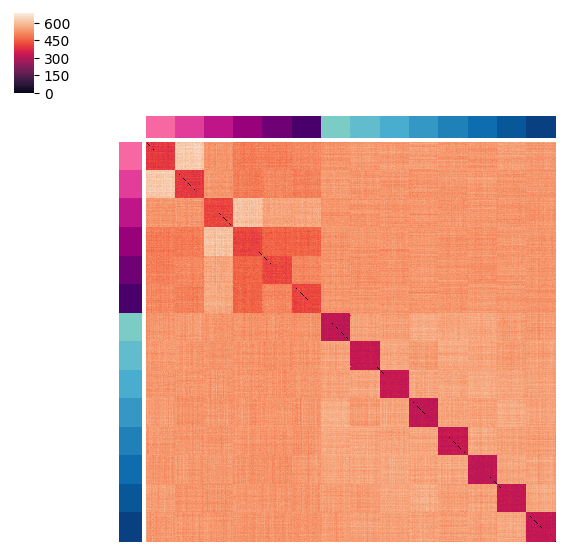

In [187]:
from sklearn.metrics import pairwise_distances
dist_feat = pairwise_distances(x_sorted.T, metric="euclidean") ** 2
plot_col_color_heatmap(dist_feat, grp_ids, lut, square=True)

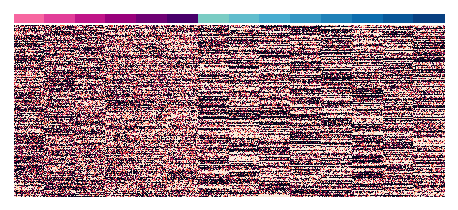

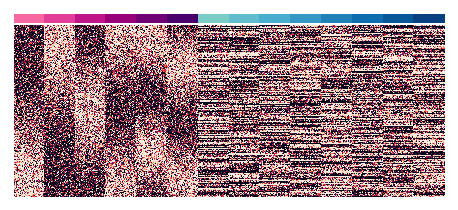

In [144]:
plot_col_color_heatmap(x_unsorted, grp_ids, lut, bound=True)
plot_col_color_heatmap(x_sorted, grp_ids, lut, bound=True)

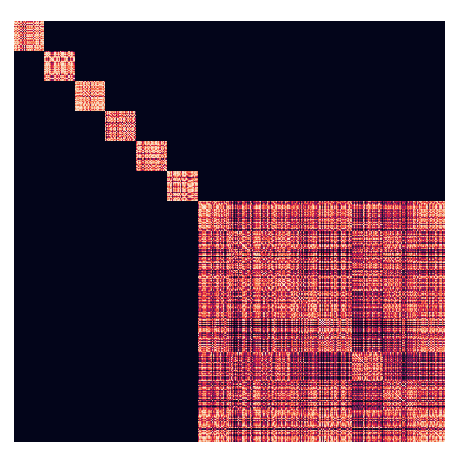

In [169]:
from graph_utils import construct_knn_naive, construct_kernal_graph
feat_network = construct_kernal_graph(x_embed.T).toarray()
plot_col_color_heatmap(feat_network, grp_ids, lut, square=True)

In [155]:
from general_utils import norm_mtx
x_sorted_norm = norm_mtx(x_sorted)

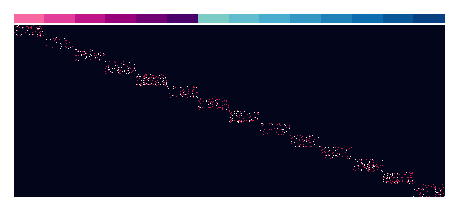

In [158]:
orig_network = construct_knn_naive(x_sorted_norm.T).toarray()
plot_col_color_heatmap(orig_network, grp_ids, lut)

In [159]:
orig_network

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [147]:
feat_network.shape

(5, 5)

In [138]:
x_embed.shape

(5, 2100)